In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from forecaster import Forecaster
from sklearn import metrics
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

df = pd.concat([train, test])
df.reset_index(inplace=True, drop=True)

In [3]:
drop_cols = [
    'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_pressure',
    'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle',
    'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle',
    'UvAerosolLayerHeight_solar_zenith_angle'
]

df.drop(columns = drop_cols, inplace=True)
df.iloc[:, :-1] = df.iloc[:, :-1].interpolate().bfill()

In [4]:
df['Date'] = [str(df.loc[i, 'year']) + '-' + str(df.loc[i, 'week_no']) + '-1' for i in range(len(df))]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%W-%w')

df['Covid'] = (df['year'] == 2020).astype(int)

In [5]:
df['latlon'] = (df['latitude'].astype(str) + df['longitude'].astype(str))
locs = df['latlon'].unique()
loc_numbers = np.arange(1, len(locs)+1)

locs = pd.DataFrame({'latlon': locs, 'location': loc_numbers})

df = df.merge(locs, on='latlon', how='left')
df = df.sort_values(by = ["year", "week_no", "location"])
df = df.drop(columns = ['year', 'week_no', 'latlon'])

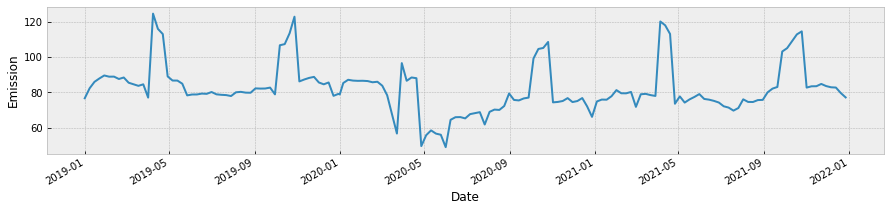

In [6]:
average_emission = df[:len(train)].groupby("Date")['emission'].mean()
ax = average_emission.plot(figsize=(15, 3))
ax.set_ylabel('Emission')
plt.show()

In [7]:
def RMSE(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred)

model = Forecaster(
    df, 
    x = 'Date', 
    y = 'emission',
    group_features = ['location'],
    keep_id = 'ID_LAT_LON_YEAR_WEEK',
    scoring_metric = RMSE
)

  0%|          | 0/497 [00:00<?, ?it/s]

,Training score,Test score
XGBRegressor,19.877683,4533.287564


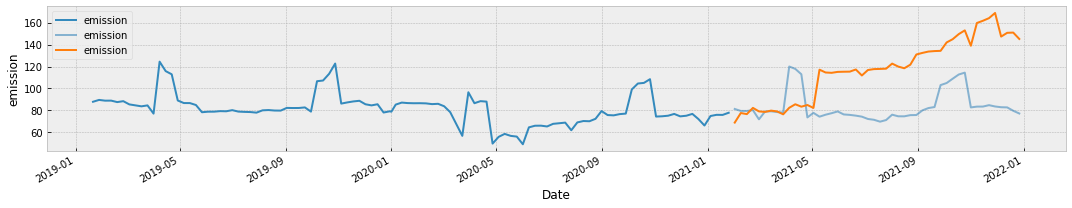

In [9]:
pred, score = model.validate(XGBRegressor, seasonality = True, lag = True, plot = True)

  0%|          | 0/497 [00:00<?, ?it/s]

,Training score
XGBRegressor,9.629097


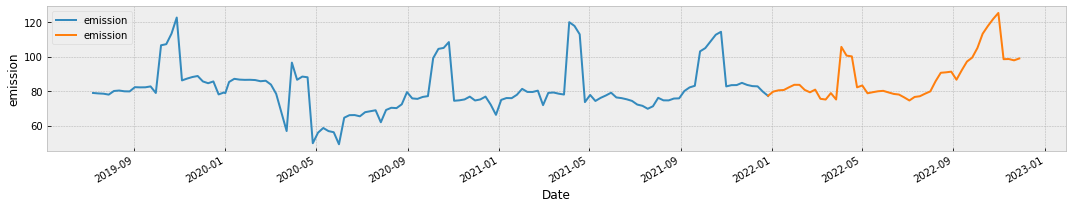

In [11]:
pred, score = model.predict(XGBRegressor, seasonality = True, lag = True, plot = True)

In [18]:
pred = pred.sort_values(by = 'ID_LAT_LON_YEAR_WEEK')

In [21]:
pred['ID_LAT_LON_YEAR_WEEK'].difference(test['ID_LAT_LON_YEAR_WEEK'])

AttributeError: 'Series' object has no attribute 'difference'

In [38]:
test['ID_LAT_LON_YEAR_WEEK'].to_frame().reset_index(drop = True).diff(pred['ID_LAT_LON_YEAR_WEEK'].to_frame().reset_index(drop = True))

ValueError: periods must be an integer

In [44]:
(~pred['ID_LAT_LON_YEAR_WEEK'].isin(test['ID_LAT_LON_YEAR_WEEK']))

Date
2021-12-27     True
2021-12-27    False
2022-01-03    False
2022-01-10    False
2022-01-17    False
              ...  
2022-10-31    False
2022-11-07    False
2022-11-14    False
2022-11-21    False
2022-11-28    False
Name: ID_LAT_LON_YEAR_WEEK, Length: 24850, dtype: bool

In [45]:
test

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.510,29.290,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.510,29.290,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.510,29.290,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.692089,3233.654973,829589.971617,14.881259,40.833582,-143.949340,26.760219,0.000055,1.679787e-05,0.000038,0.00

In [46]:
pred

,ID_LAT_LON_YEAR_WEEK,emission
Date,,
2021-12-27,ID_-0.510_29.290_2021_52,4.236501
2021-12-27,ID_-0.510_29.290_2022_00,4.236501
2022-01-03,ID_-0.510_29.290_2022_01,6.453243
2022-01-10,ID_-0.510_29.290_2022_02,5.604754
2022-01-17,ID_-0.510_29.290_2022_03,5.229881
...,...,...
2022-10-31,ID_-3.299_30.301_2022_44,37.247322
2022-11-07,ID_-3.299_30.301_2022_45,35.772789
2022-11-14,ID_-3.299_30.301_2022_46,36.251663


In [81]:
np.where(pd.Series(df['Date'].unique()) == '2018-12-31')[0][0]

0

In [83]:
pd.Series(df['Date'].unique())[np.where(pd.Series(df['Date'].unique()) == '2018-12-31')[0][0] + 1]

Timestamp('2019-01-07 00:00:00')

In [84]:
df['Date'].unique()

array(['2018-12-31T00:00:00.000000000', '2019-01-07T00:00:00.000000000',
       '2019-01-14T00:00:00.000000000', '2019-01-21T00:00:00.000000000',
       '2019-01-28T00:00:00.000000000', '2019-02-04T00:00:00.000000000',
       '2019-02-11T00:00:00.000000000', '2019-02-18T00:00:00.000000000',
       '2019-02-25T00:00:00.000000000', '2019-03-04T00:00:00.000000000',
       '2019-03-11T00:00:00.000000000', '2019-03-18T00:00:00.000000000',
       '2019-03-25T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-04-08T00:00:00.000000000', '2019-04-15T00:00:00.000000000',
       '2019-04-22T00:00:00.000000000', '2019-04-29T00:00:00.000000000',
       '2019-05-06T00:00:00.000000000', '2019-05-13T00:00:00.000000000',
       '2019-05-20T00:00:00.000000000', '2019-05-27T00:00:00.000000000',
       '2019-06-03T00:00:00.000000000', '2019-06-10T00:00:00.000000000',
       '2019-06-17T00:00:00.000000000', '2019-06-24T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-07-08

In [73]:
df

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,Date,Covid,location
0,ID_-0.510_29.290_2019_00,-0.510,29.290,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-2.715031e-05,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,0.000047,0.000016,0.000030,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,2018-12-31,0,1
159,ID_-0.528_29.472_2019_00,-0.528,29.472,0.000019,0.709144,0.000014,0.134741,-98.501511,51.844101,-129.869812,36.068928,5.691926e-06,0.035727,2645.175390,3417.572013,829790.960162,-12.807893,52.099334,-139.690585,31.073971,0.000072,0.000042,0.000030,0.000122,7311.869141,-0.937088,0.077533,830076.312500,-98.501511,51.844101,-129.869812,36.068928,0.000319,0.817855,0.000198,0.134741,36.068928,-129.869812,51.844101,-98.501511,-1.054328,829868.890625,-12.516434,35.564114,-138.522350,30.907028,0.116943,2.493509,0.296229,227.198841,0.569428,-12.516434,35.564114,-138.522350,30.907028,0.569586,57785.435180,4001.152273,63069.690906,3213.283931,18.926705,0.214483,-12.516482,35.564368,-138.523453,30.907505,3.857115,2018-12-31,0,2
318,ID_-0.547_29.653_2019_00,-0.547,29.653,-0.000003,0.644523,0.000002,0.159232,-98.442759,52.516869,-129.718869,36.191228,7.850610e-07,0.039741,2061.904541,3321.773193,829546.187500,71.237350,51.419987,-149.304703,26.124090,0.000062,0.000031,0.000030,0.000115,7311.869141,-0.915535,0.099072,830080.13503

In [63]:
df['Date'][0]

Timestamp('2018-12-31 00:00:00')

In [64]:
df['Date'].unique()[0]

numpy.datetime64('2018-12-31T00:00:00.000000000')

In [70]:
list(pd.Series(df['Date'].unique())).index('2018-12-31')

ValueError: '2018-12-31' is not in list